In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def jpg_image_to_array(image_path, size):
    # open image
    image = Image.open(image_path)
    # resize
    image = image.resize((size, size))  
    # convert to int ndarray, 크기는 항상 size*size*3 형태로
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)  
    im_arr=im_arr/255
    # reshape to (size, size, 3)
    im_arr = im_arr.reshape((image.size[0], image.size[1], 3)) 
    return im_arr

# convert to 1-channel by averaging
def image_array_to_1channel(arr):
    arr_avg = (arr[:,:,0]+arr[:,:,1]+arr[:,:,2])/3   
    return arr_avg

C:\anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


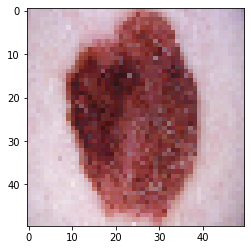

In [2]:
import json
import os
import numpy as np

dir="folder"
#dir폴더의 모든 파일들 이름 저장
subdir_names = os.listdir(dir)
size=len(subdir_names)

x_train=[]
y_train=[]

input_size=50



for i in range(0,size,2):
    #첫번쨰는 사진, 두번쨰는 josn
    name_of_jpg=subdir_names[i]
    name_of_json=subdir_names[i+1]
    isUsed=True #benign과 malignant만 학습에 사용
    
    json_path="./"+dir+"/"+name_of_json
    try:
    #json 파일에서 클래스 추출
        with open(json_path) as json_file:
            json_data=json.load(json_file)
            clas=json_data["meta"]["clinical"]["benign_malignant"]
            if clas=="benign":
                y_train=np.append(y_train,0)
            elif clas=="malignant":
                y_train=np.append(y_train,1)
            else:
                isUsed=False
                continue
    except:
        continue
        
    if isUsed:
        jpg_path="./"+dir+"/"+name_of_jpg
        arr=jpg_image_to_array(jpg_path,input_size)
        
        if len(x_train)==0:
            x_train=[arr]
        else:
            x_train=np.concatenate((x_train,[arr]))
        
        plt.imshow(arr, cmap=plt.get_cmap('gray'))
 

In [3]:
x_train = x_train.astype('float32')
print(len(x_train))

12162


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, utils


def model_cnn(x,y,epochs,batch_size,learning_rate,dropout_rate,input_size):
    # CNN model design
    model = tf.keras.Sequential()

    # kernel개수, kernel size(5,5), (행strides,열stride), padding을 이용하여 input과 output 크기 유지)
    # 파라미터수 416=5*5*16+16(바이어스 : 커널당 1개)
    model.add(layers.Conv2D(16, (5, 5), strides=(1, 1), padding='same',
                     activation='relu', input_shape=(input_size,input_size,3), 
                     name='conv1'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same', 
                     name='pool1'))

    # 파라미터수 12832=5*5*32*16+32(바이어스 : 커널당 1개)
    model.add(layers.Conv2D(32, (5, 5), activation='relu', 
                     name='conv2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same', 
                     name='pool2'))

    # 3차원을 1차원으로 바꿔줌 ( ex) [[[1],[2]],[[1],[3]],[[1],[2]]] -> [1,2,1,3,1,2] )
    model.add(layers.Flatten())

    #Field Forward Network 시작
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(lr=learning_rate),
                  metrics=['accuracy'])
    
    #학습시작
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    hist = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,
                     callbacks=[early_stop], 
                     shuffle=True,
                     verbose=1)

    #학습시킨 모델을 저장 해당디렉토리에 저장
    return model,hist


In [6]:
import matplotlib.pyplot as plt
def grapviz(hist):
    fig, loss_ax = plt.subplots(figsize=(10, 5))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [26]:
model,hist=model_cnn(x_train[:10000],y_train[:10000],500,100,0.1,0.5,input_size)

Train on 8000 samples, validate on 2000 samples
Epoch 1/500
8000/8000 [==============================] - 14s 2ms/sample - loss: 0.4786 - accuracy: 0.8067 - val_loss: 0.3400 - val_accuracy: 0.8970
Epoch 2/500
8000/8000 [==============================] - 13s 2ms/sample - loss: 0.4700 - accuracy: 0.8134 - val_loss: 0.3217 - val_accuracy: 0.8970
Epoch 3/500
8000/8000 [==============================] - 13s 2ms/sample - loss: 0.4653 - accuracy: 0.8135 - val_loss: 0.3205 - val_accuracy: 0.8970
Epoch 4/500
8000/8000 [==============================] - 13s 2ms/sample - loss: 0.4627 - accuracy: 0.8133 - val_loss: 0.3140 - val_accuracy: 0.8970
Epoch 5/500
8000/8000 [==============================] - 12s 2ms/sample - loss: 0.4601 - accuracy: 0.8135 - val_loss: 0.3903 - val_accuracy: 0.8965
Epoch 6/500
8000/8000 [==============================] - 14s 2ms/sample - loss: 0.4567 - accuracy: 0.8135 - val_loss: 0.3339 - val_accuracy: 0.8970
Epoch 7/500
8000/8000 [==============================] - 14s 2ms

KeyboardInterrupt: 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 50, 50, 16)        1216      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 25, 25, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 21, 21, 32)        12832     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               495744    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

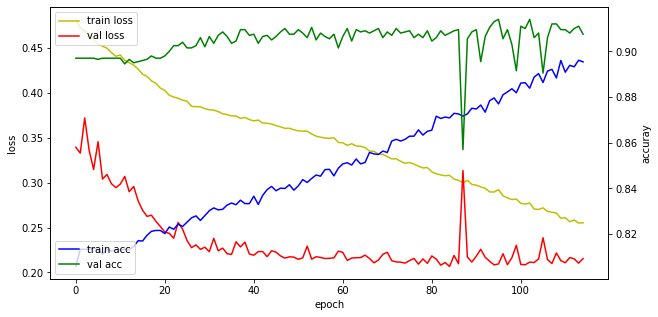

In [10]:
model.save("CNN_model.h5")
model.summary()
grapviz(hist)

In [20]:
score=model.evaluate(x_train[10000:],y_train[10000:],verbose=1)
print("test_loss:",score[0])
print("test_accuracy:",score[1])

2162/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test_loss: 0.43385169017546493
test_accuracy: 0.8052729


In [22]:
score=model.evaluate(x_train[10000:],y_train[10000:],verbose=1)
print("test_loss:",score[0])
print("test_accuracy:",score[1])

2162/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test_loss: 0.43385169017546493
test_accuracy: 0.8052729
